In [21]:
import sys
if '/disks/cosmodm/vdvuurst' not in sys.path:
    sys.path.append('/disks/cosmodm/vdvuurst')

import numpy as np
import h5py
from matplotlib import pyplot as plt
import os
from importlib import reload
import json
import ONEHALO
from tqdm import tqdm
from functions import modified_logspace, Romberg
from onehalo_plotter import *
format_plot()

In [22]:
method = 'emcee'
rootpath = f'/disks/cosmodm/vdvuurst/data/OneHalo_param_fits/{method}'
rbins = modified_logspace(0, 5, 18)
rbin_centers = np.array([np.mean(rbins[i:i+2]) for i in range(17)])


def radial_param_scraper(rootpath, lower_mass = 2, upper_mass = 5.5, step = 0.5, rbins = rbins, save = False):
    mass_range = np.arange(lower_mass, upper_mass + step, step).astype(np.float32)
    mass_bins = [f'M_1{mass_range[i]}-1{mass_range[i+1]}' for i in range(len(mass_range)-1)]

    rbin_keys = np.array([f'r_{rbins[i]:.2f}-{rbins[i+1]:.2f}' for i in range(len(rbins) - 1)])

    params = ['sigma_1', 'sigma_2', 'lambda']

    mass_dict = {mass_bin: {p:np.full(rbin_centers.shape, -1, dtype = np.float32) for p in params} for mass_bin in mass_bins}
    for mass_bin in mass_bins:
        mass_dict[mass_bin]['sigma1_errors'] = np.full((*rbin_centers.shape,2), 0, dtype = np.float32)
        mass_dict[mass_bin]['sigma2_errors'] = np.full((*rbin_centers.shape,2), 0, dtype = np.float32)
        mass_dict[mass_bin]['lambda_errors'] = np.full((*rbin_centers.shape,2), 0, dtype = np.float32)

    for subdir, _, files in os.walk(rootpath):
        for file in files:
            if 'r_' in file and 'log' not in file: 
                mass_bin_str = os.path.split(subdir)[1]
                rbin_str = file.split('.json')[0]
                filepath = os.path.join(subdir, file)
                
                with open(filepath, 'r') as handle:
                    data = json.load(handle)
                
                r_index = np.where(rbin_keys == rbin_str)[0][0]

                for key,value in data.items():
                    try:
                        if key in ['nwalkers', 'nsteps']:
                            continue
                        elif key == 'errors':
                            sigma1err, sigma2err, lambdaerr = value
                            mass_dict[mass_bin_str]['sigma1_errors'][r_index] = sigma1err
                            mass_dict[mass_bin_str]['sigma2_errors'][r_index] = sigma2err
                            mass_dict[mass_bin_str]['lambda_errors'][r_index] = lambdaerr
                        else:
                            mass_dict[mass_bin_str][key][r_index] = value 
                    #TODO: with the try/except i do no errors for minimize now. but they should be just 0
                    except KeyError:
                        continue 

    #numpy to list
    for mbin in mass_bins:
        for p in params:
            data = mass_dict[mbin][p]
            mass_dict[mbin][p] = data.tolist()

    if save:
        with open(f'/disks/cosmodm/vdvuurst/data/OneHalo_param_fits/{method}/full_radial.json', 'w') as file:
            json.dump(mass_dict, file, indent = 1)
    
    return mass_dict

mass_dict = radial_param_scraper(rootpath)
# mass_dict['M_12.0-12.5']['sigma_1']
mass_dict

{'M_12.0-12.5': {'sigma_1': [85.41521453857422,
   115.49080657958984,
   109.90128326416016,
   95.18810272216797,
   104.21601104736328,
   104.06257629394531,
   104.603759765625,
   150.20449829101562,
   111.15495300292969,
   119.27269744873047,
   114.3077163696289,
   228.52967834472656,
   150.4660186767578,
   -1.0,
   -1.0,
   -1.0,
   -1.0],
  'sigma_2': [138.4933624267578,
   461.887451171875,
   427.8052673339844,
   125.0996322631836,
   411.9301452636719,
   426.3106384277344,
   395.099365234375,
   86.05685424804688,
   389.8851623535156,
   398.6888427734375,
   257.3771667480469,
   114.10234069824219,
   309.0415954589844,
   -1.0,
   -1.0,
   -1.0,
   -1.0],
  'lambda': [0.49999794363975525,
   0.0003216293116565794,
   0.0007183444104157388,
   0.4250932037830353,
   0.0025264201685786247,
   0.004081184510141611,
   0.007496800739318132,
   0.49999916553497314,
   0.01580788940191269,
   0.0238500889390707,
   0.10808984935283661,
   0.4999581575393677,
   0.444

In [23]:
from scipy.optimize import curve_fit

def const_func(r,a):
    return np.full_like(r, a)

def linear_func(r, m, c):
    return m * r + c

def parabola_func(r, a, b, c):
    return a * r**2 + b * r + c

def exp_func(r, A, B, C):
    return A * np.exp(-B * r) + C

def exp_sq_func(r, A, B, C):
    return A * np.exp(-B * r**2) + C

def power_law_func(r, p, n, q):
    return p * np.power(r, n) + q

def power_linear_func(r, p, n, q, b):
    return p * np.power(r, n) + q * r + b

with open('/disks/cosmodm/vdvuurst/data/initial_params.json', 'r') as file:
    initial_params_full = json.load(file)
latex_formatter = {'sigma_1':r'$\sigma_1$', 'sigma_2': r'$\sigma_2$', 'lambda':r'$\lambda$'}

def fit_previous_best():

    for key, mass_bin_dict in mass_dict.items():
    # mass_bin_dict = mass_dict['M_12.5-13.0']

        # print(initial_params)
        if key in ['M_12.0-12.5','M_12.5-13.0','M_15.0-15.5']: # these are all 0 since Sowmya didn't do them before
            mkey = 'M_13.5-14.0'
        else:
            mkey = key
        initial_params = initial_params_full[mkey]

        sigma_1_init = np.array([initial_params[x] for x in ['p', 'n', 'q', 'b']])
        sigma_2_init = np.array([initial_params[x] for x in ['m', 'c']])
        lambda_init = np.array([initial_params[x] for x in ['A', 'B', 'C']])

        fig, axes = plt.subplots(nrows = 3, figsize = (10,10), sharex = False)
        for i,(param, values) in enumerate(mass_bin_dict.items()):
            # axes[i].set_title(latex_formatter[param])
            if 'errors' in param:
                continue
        
            match param:
                case 'sigma_1':
                    p0 = sigma_1_init
                    fit_func = power_linear_func
                    err = mass_bin_dict['sigma1_errors']

                case 'sigma_2':
                    p0 = sigma_2_init
                    fit_func = linear_func
                    err = mass_bin_dict['sigma2_errors']

                case 'lambda':
                    p0 = lambda_init
                    fit_func = exp_func
                    err = mass_bin_dict['lambda_errors']

            valid_idx = np.array(values) != -1
            try:
                popt, pcov = curve_fit(fit_func, xdata = rbin_centers[valid_idx], ydata = np.array(values)[valid_idx], p0 = p0, maxfev = 5000,
                                        sigma = np.mean(err[valid_idx], axis = 1))
                err_flag = False
            except RuntimeError:
                err_flag = True

            axes[i].errorbar(rbin_centers[valid_idx], np.array(values)[valid_idx], yerr = err[valid_idx].transpose(), fmt = '.', capsize = 2, color = 'black')

            if not err_flag:
                xvalues = np.linspace(np.min(rbin_centers[valid_idx]),np.max(rbin_centers[valid_idx]), 1000)
                match param:
                    case 'sigma_1':
                        yvalues = power_linear_func(xvalues, *popt)
                    case 'sigma_2':
                        yvalues = linear_func(xvalues, *popt)
                    case 'lambda':
                        yvalues = exp_func(xvalues, *popt)

                axes[i].plot(xvalues, yvalues, c = 'black')

            axes[i].set(ylabel = latex_formatter[param])
            axes[i].set(xlabel = 'r')
            axes[i].ticklabel_format(useOffset=False)

        plt.suptitle(key.replace('_',' = ')+' dex', fontsize = 20)
        plt.tight_layout()
        plt.show()
    
# fit_previous_best()

/var/tmp/vdvuurst/ipykernel_561832/40641206.py:16: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-B * r**2) + C


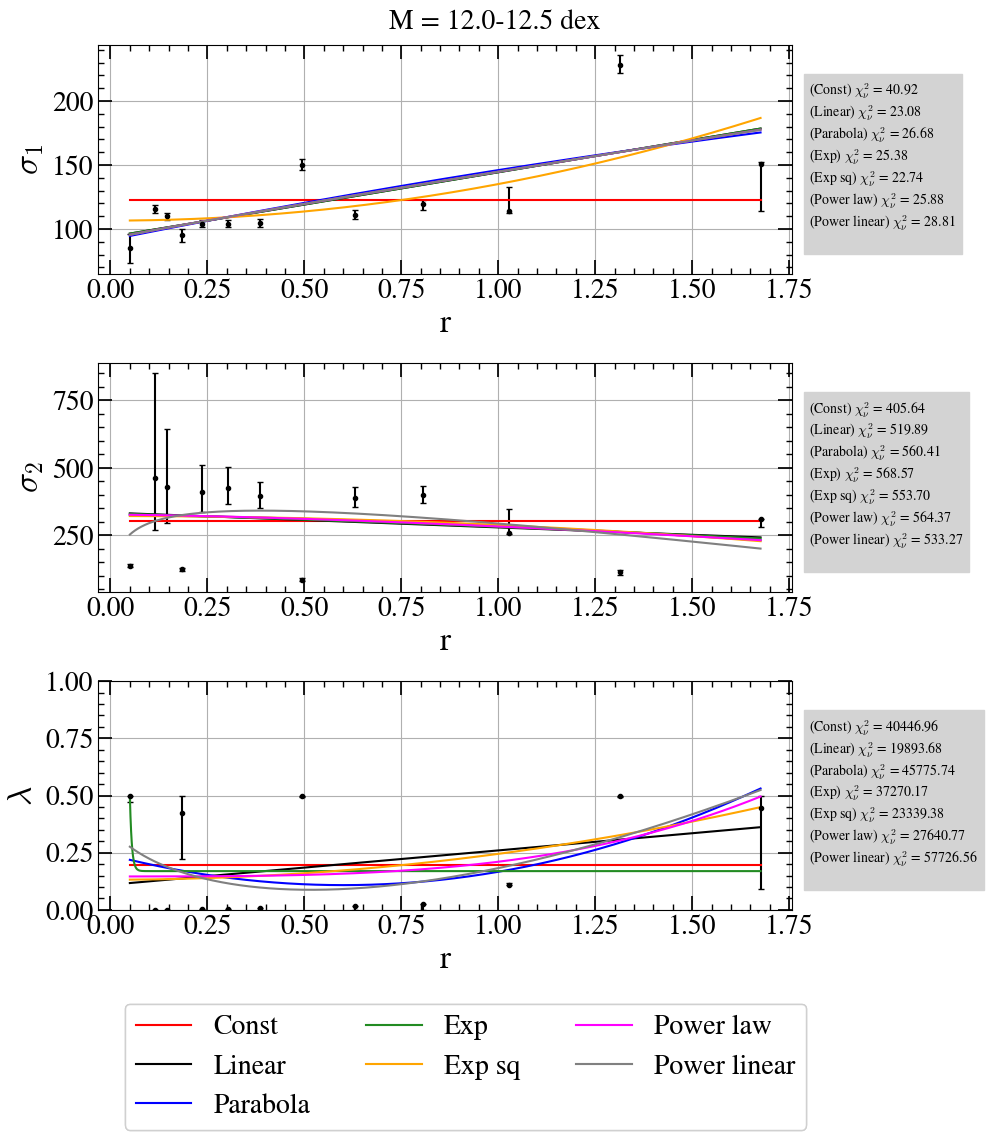

/var/tmp/vdvuurst/ipykernel_561832/40641206.py:13: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-B * r) + C


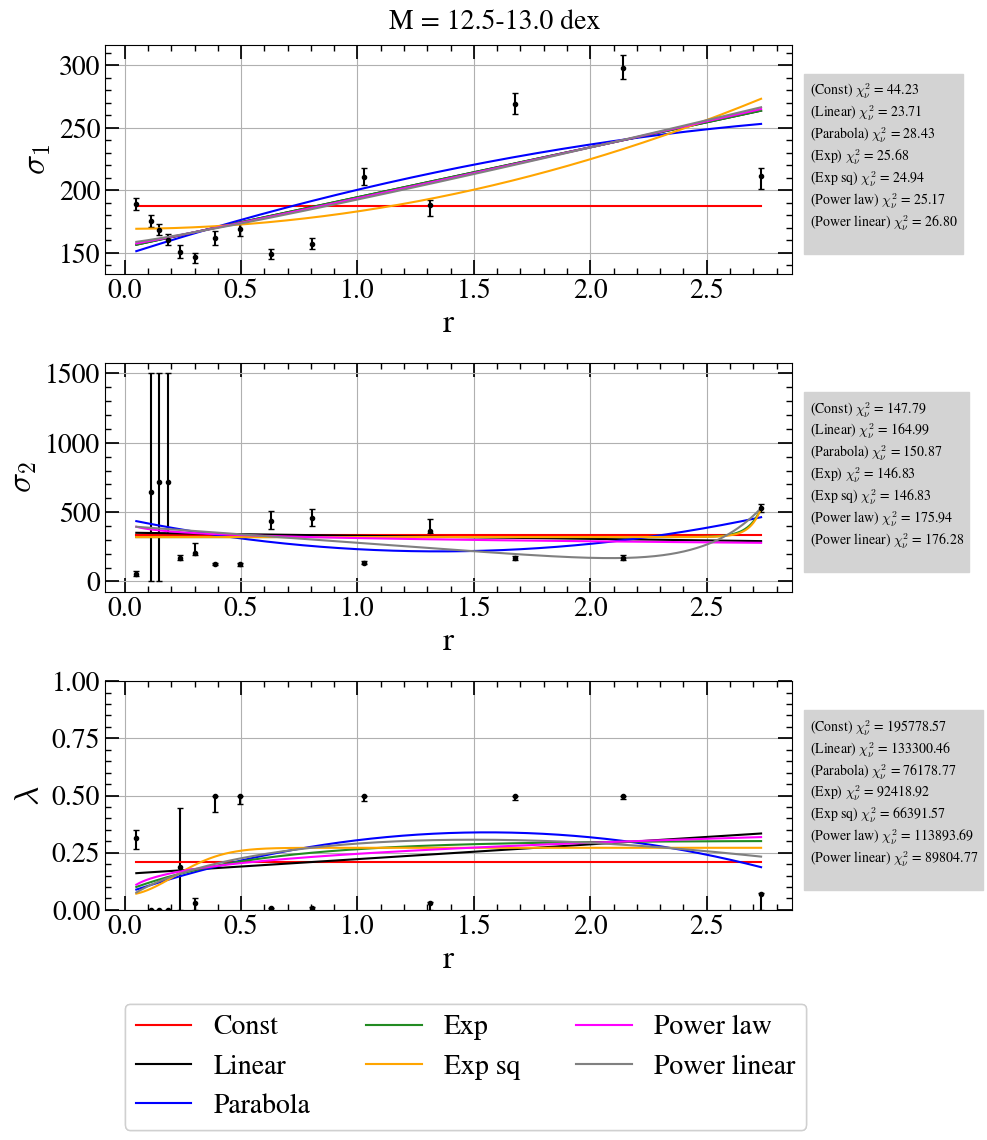

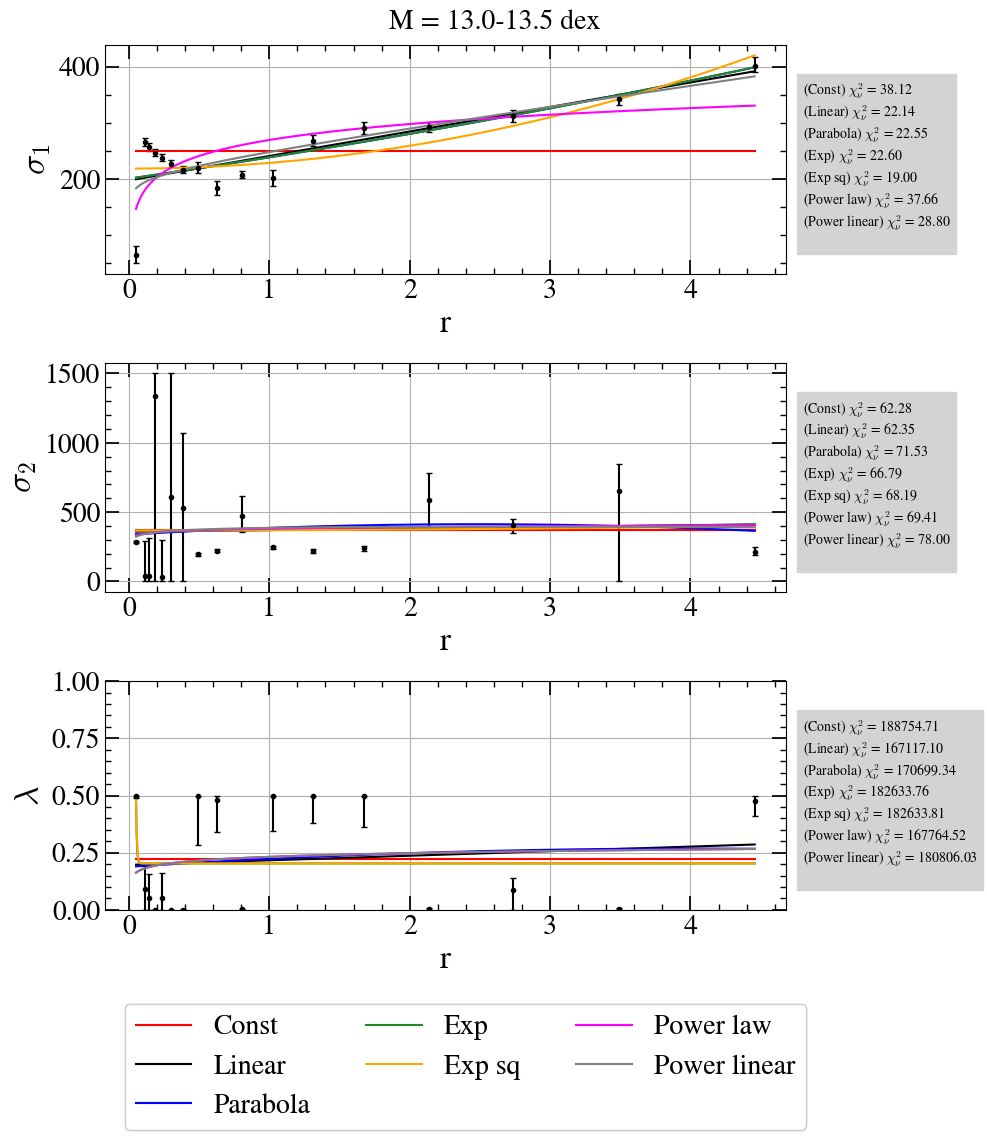

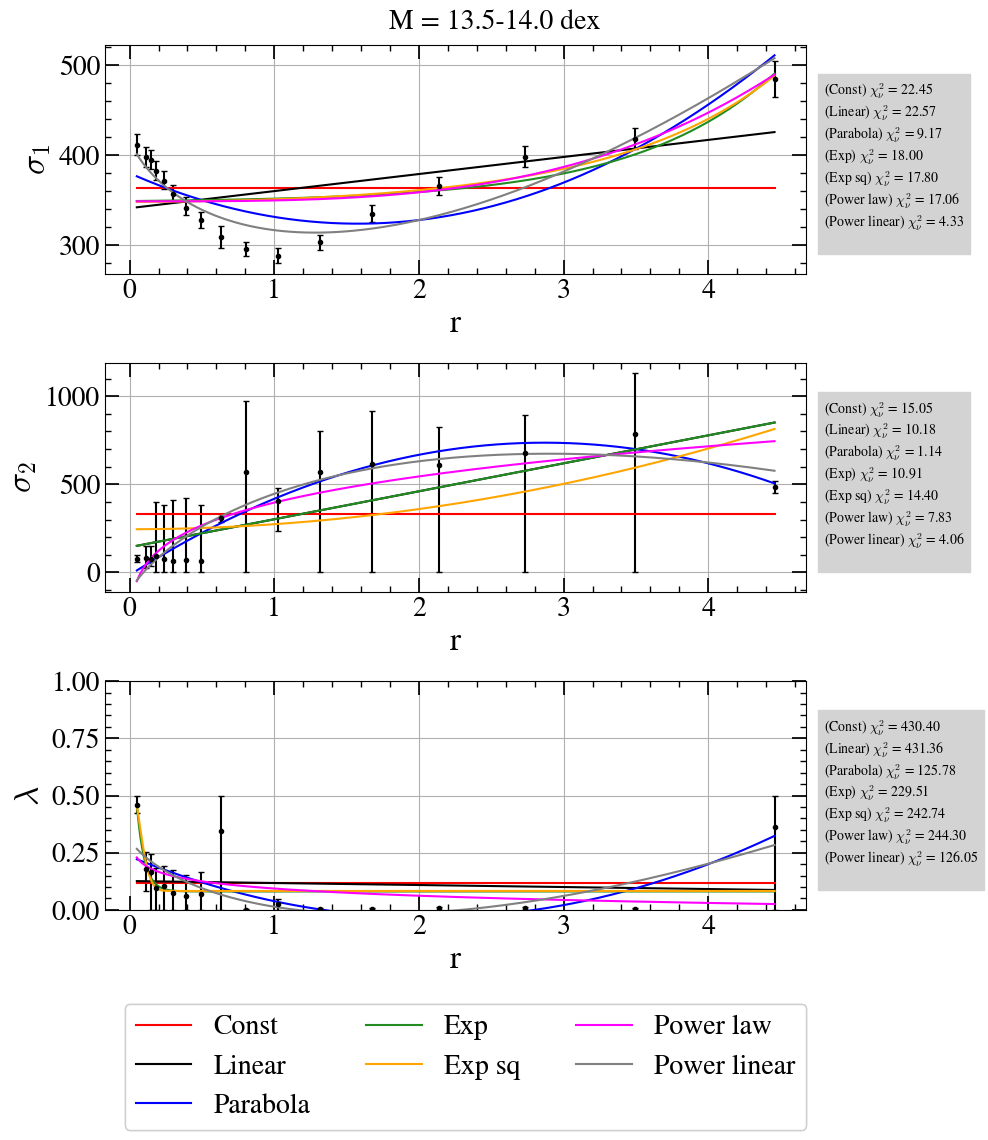

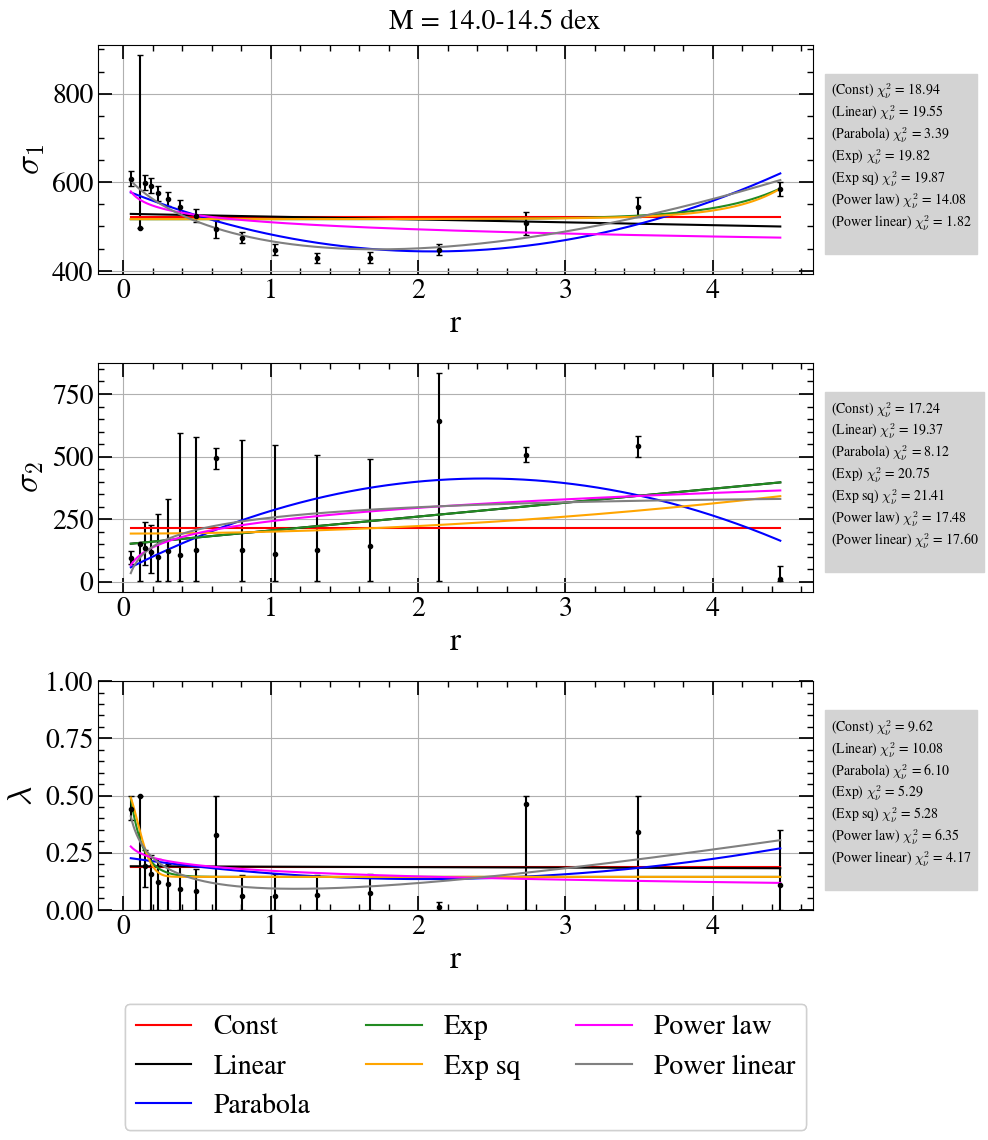

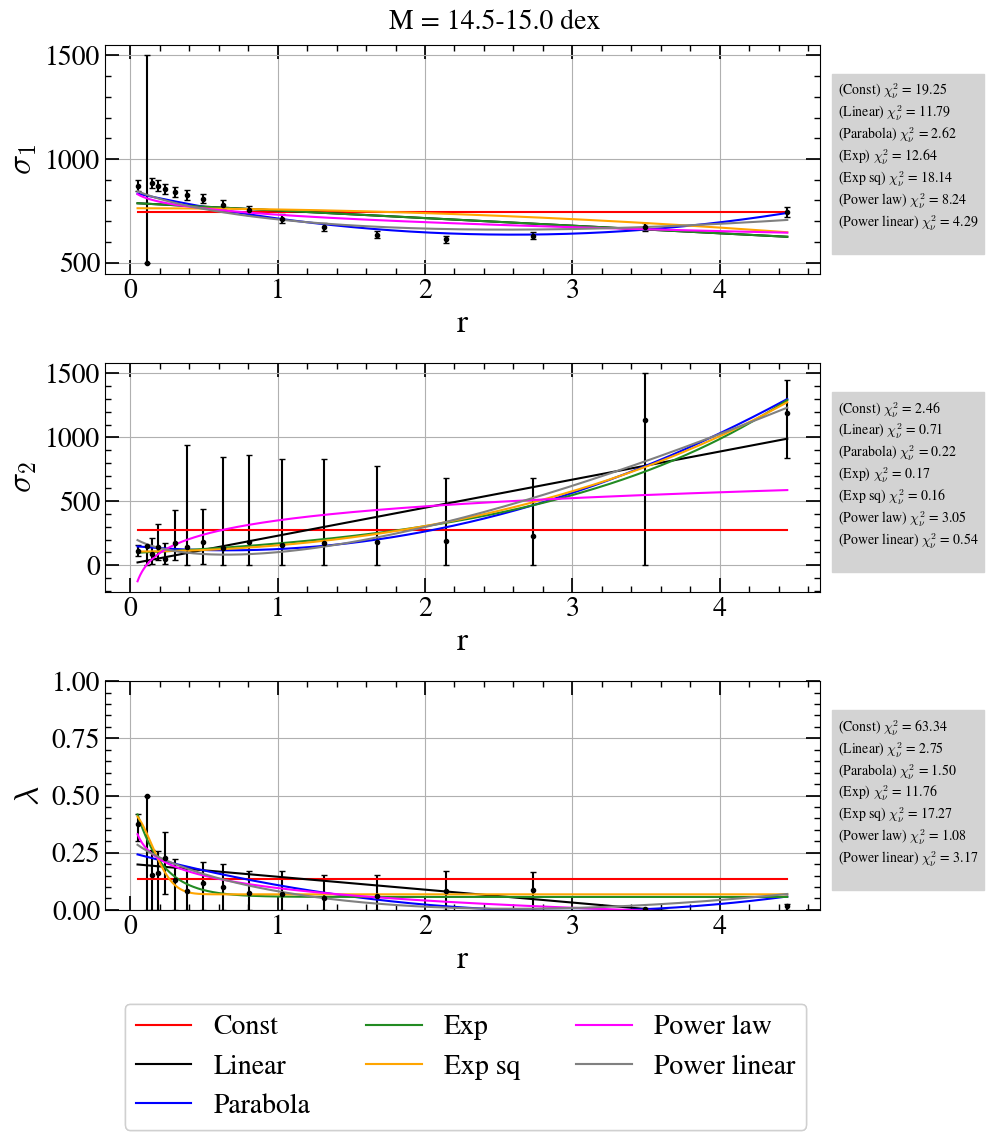

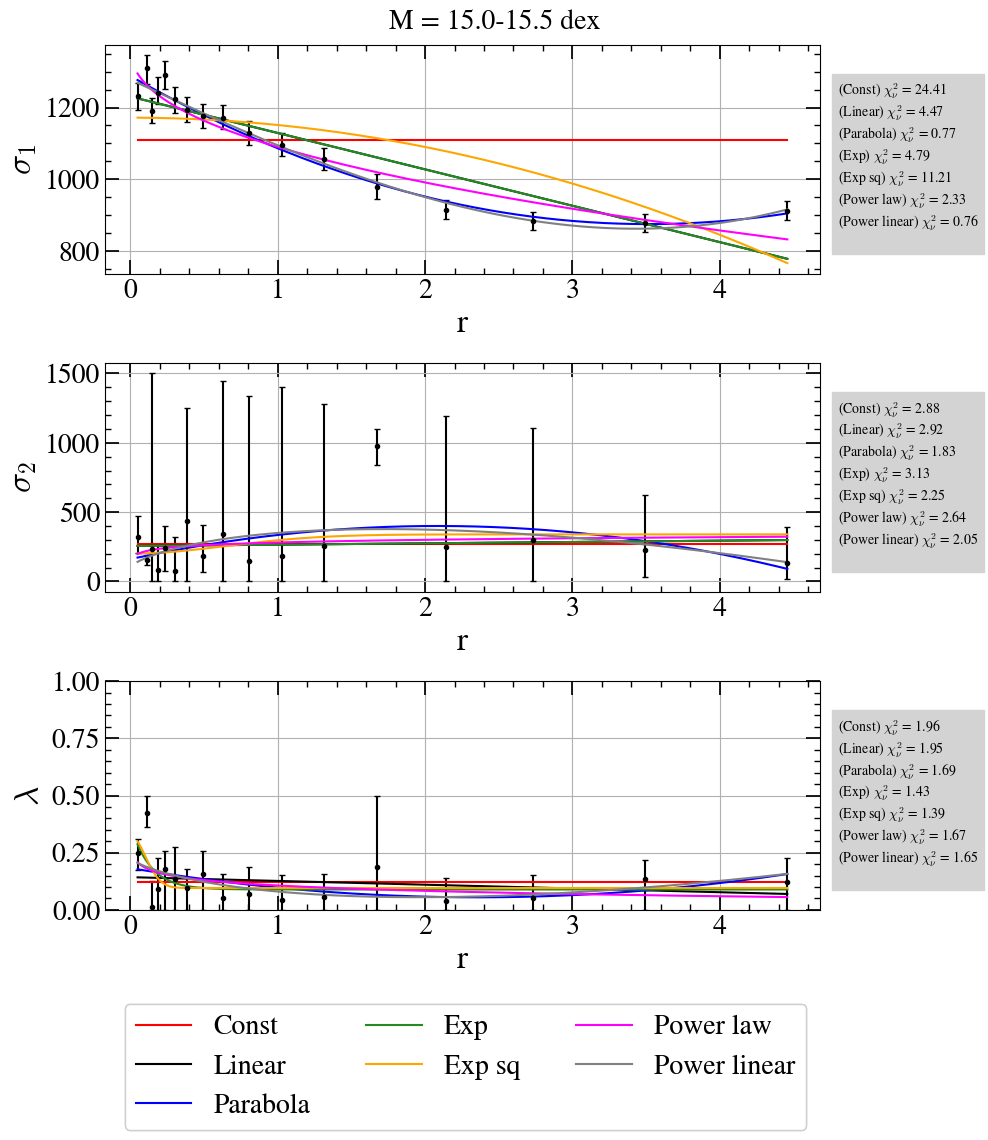

In [24]:
all_funcs = [const_func, linear_func, parabola_func, exp_func, exp_sq_func, power_law_func, power_linear_func]
func_names = [f.__name__.split('_func')[0] for f in all_funcs]
colors = ['red', 'black', 'blue', 'forestgreen', 'orange', 'magenta', 'gray']
color_dict = dict(zip(func_names,colors))
func_dict = dict(zip(func_names, all_funcs))


def reduced_chi2(O, E, sigma, dof):
    return np.sum(np.square(O - E) / sigma** 2) / dof


def fit_all_forms(range_str = None, skip_radbin = None):
    
    for key, mass_bin_dict in mass_dict.items():
        if range_str:
            mass_bin_dict = mass_dict[range_str]
            key = range_str

        # print(initial_params)
        if key in ['M_12.0-12.5','M_12.5-13.0','M_15.0-15.5']: # these are all 0 since Sowmya didn't do them before
            mkey = 'M_13.5-14.0'
        else:
            mkey = key
        initial_params = initial_params_full[mkey]

        if range_str:
            mkey = range_str

        # initial params based on sowmya's results and for the new function based on those
        # need only be in the ballpark
        power_linear_init = np.array([initial_params[x] for x in ['p', 'n', 'q', 'b']])
        linear_init = np.array([initial_params[x] for x in ['m', 'c']])
        exp_init = np.array([initial_params[x] for x in ['A', 'B', 'C']])
        exp_sq_init = exp_init.copy()
        power_law_init = power_linear_init.copy()[:-1]
        const_init = 400.
        parabola_init = np.hstack(([1], linear_init))

        init_list = [const_init, linear_init, parabola_init, exp_init, exp_sq_init, power_law_init, power_linear_init]

        fig, axes = plt.subplots(nrows = 3, figsize = (10,10), sharex = False)
        no_err = [True, True, True]
        for i,(param, values) in enumerate(mass_bin_dict.items()):
            if 'errors' in param:
                continue
            values = np.array(values)

            match param:
                case 'sigma_1':
                    err = mass_bin_dict['sigma1_errors']
                    valid_idx = np.array(values) != -1
                case 'sigma_2':
                    err = mass_bin_dict['sigma2_errors']
                    valid_idx = np.array(values) != -1
                case 'lambda':
                    err = mass_bin_dict['lambda_errors']
                    # values[0] = 1- values[0]
                    # err[0] = np.flip(err[0])
                    # values[-4:] = 1 - np.array(values[-4:])

                    valid_idx = np.array(values) != -1
                    # valid_idx[0] = False
            if skip_radbin is not None:
                print(valid_idx)
                valid_idx[skip_radbin] = False
                print(valid_idx)
            #plot the data
            axes[i].errorbar(rbin_centers[valid_idx], np.array(values)[valid_idx],
                                yerr = err[valid_idx].transpose(), fmt = '.', capsize = 2, color = 'black')
            
            # loop over all functions for this parameter in this mass bin
            paramstr = ''
            for fit_func, func_name, init in zip(all_funcs,func_names,init_list):
                try:
                    xdata = rbin_centers[valid_idx]
                    ydata = np.array(values)[valid_idx]
                    errs = np.mean(err[valid_idx], axis = 1)
                    popt, pcov = curve_fit(fit_func, xdata = xdata, ydata = ydata,
                                            p0 = init, maxfev = 5000)
                                            # sigma = errs)
                    err_flag = False

                except RuntimeError:
                    print(f'ERROR OCCURED IN MASS BIN {key} FOR {param} on function {func_name}')
                    err_flag = True
                    no_err[i] = False

                if not err_flag:
                    pretty_func_label = f'{func_name[0].upper()}{func_name[1:].replace('_',' ')}'
                    # every function has a different number of parameters
                    num_args = len(popt)
                    dof = rbin_centers[valid_idx].size - num_args
                    chi2 = reduced_chi2(ydata, fit_func(xdata, *popt), errs, dof)
                    paramstr += f'({pretty_func_label}) ' + r'$\chi^2_{\nu}$ = ' + f'{chi2:.2f}\n'

                    xvalues = np.linspace(np.min(rbin_centers[valid_idx]),np.max(rbin_centers[valid_idx]), 1000)
                    yvalues = fit_func(xvalues, *popt)
                    axes[i].plot(xvalues, yvalues, label = pretty_func_label, c = color_dict[func_name])

            axes[i].text(1.025,0.125,paramstr,fontsize=10,backgroundcolor='lightgray',zorder=-1,transform=axes[i].transAxes)


            try:
                j = np.where(no_err)[0][0]
            except IndexError:
                j = -1

            handles, labels = axes[j].get_legend_handles_labels()
            fig.legend(handles, labels, bbox_to_anchor = [0.825, 0], ncols = 3)
            # make plot prettier
            axes[i].set(ylabel = latex_formatter[param])
            axes[i].set(xlabel = 'r')
            axes[i].ticklabel_format(useOffset=False)
            axes[i].grid()

        axes[-1].set_ylim(0,1)
        plt.suptitle(key.replace('_',' = ')+' dex', fontsize = 20)
        plt.tight_layout()
        plt.show()

        if range_str:
            break

# fit_all_forms('M_13.5-14.0', skip_radbin = -1)
fit_all_forms()